In [ ]:
import gc
import os
import cv2
import time
import imutils
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from imutils import paths
from statistics import mean
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime as dt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model, Sequential
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling1D


!unzip '/content/FilledHoles.zip' -d '/content/'

# Reading WAT Images
imagePaths = list(paths.list_images(r"/content/WAT"))

data = []
labels = []

for imagePath in imagePaths:
  image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)
  image = image[24:74,24:74] # Crop images to 50 x 50 pixels
  data.append(image)
  label = 0
  labels.append(label)
print("Loaded WAT...")

# Reading NAT Images
imagePaths = list(paths.list_images(r"/content/NAT"))

for imagePath in imagePaths:
  image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)
  image = image[24:74,24:74] # Crop images to 50 x 50 pixels
  data.append(image)
  label = 1
  labels.append(label)
print("Loaded NAT...")

labels = np.array(labels,dtype='uint8')
data = np.array(data,dtype='uint8')

data.shape

Archive:  /content/FilledHoles.zip
   creating: /content/NAT/
 extracting: /content/NAT/J0012-0607.png  
 extracting: /content/NAT/J0017+0827.png  
 extracting: /content/NAT/J0020+0004.png  
 extracting: /content/NAT/J0020-1121.png  
 extracting: /content/NAT/J0023+0717.png  
 extracting: /content/NAT/J0041-0922.png  
 extracting: /content/NAT/J0041-0925.png  
 extracting: /content/NAT/J0047+1034.png  
 extracting: /content/NAT/J0054+0302.png  
 extracting: /content/NAT/J0056-0119.png  
 extracting: /content/NAT/J0056-0120.png  
 extracting: /content/NAT/J0104-0024.png  
 extracting: /content/NAT/J0111+1141.png  
 extracting: /content/NAT/J0119-1003.png  
 extracting: /content/NAT/J0132+0115.png  
 extracting: /content/NAT/J0140+0223.png  
 extracting: /content/NAT/J0148+0000.png  
 extracting: /content/NAT/J0148+0142.png  
 extracting: /content/NAT/J0150-0818.png  
 extracting: /content/NAT/J0210-0633.png  
 extracting: /content/NAT/J0212-0155.png  
 extracting: /content/NAT/J0212-082

(1282, 50, 50)

In [ ]:
# Flatten Images
data = data.reshape((len(data),50*50))
data = pd.DataFrame(data)
labels = pd.DataFrame(labels)
BB = pd.concat([data,labels], axis=1)
WAT = BB[0:848]
NAT = BB[848:]

data.shape

(1282, 2500)

In [14]:
# # Choose Number of Samples per Class ; Max is 2000 for a Balanced Dataset
samplesize=400

# # Balancing the Dataset
WAT_s = WAT.sample(n=samplesize,random_state=42)
NAT_s = NAT.sample(n=samplesize,random_state=42)
Images_s = pd.concat([WAT_s,NAT_s])
Images_s = shuffle(Images_s,random_state=42)
lbl = Images_s.iloc[:,-1:]
Imgs = Images_s.iloc[:,:-1]
Imgs = np.array(Imgs)
lbl = np.array(lbl)


print("\nWAT_s shape:", WAT_s.shape)
print("NAT_s shape:", NAT_s.shape)
print("\nImages_s shape:", Images_s.shape)
print("\nLabels (lbl) shape:", lbl.shape)
print("First 10 labels:", lbl[:10])
print("Label counts:", np.unique(lbl, return_counts=True))


WAT_s shape: (400, 2501)
NAT_s shape: (400, 2501)

Images_s shape: (800, 2501)

Labels (lbl) shape: (800, 1)
First 10 labels: [[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]]
Label counts: (array([0, 1], dtype=uint8), array([400, 400]))


In [15]:

onehot_encoder = OneHotEncoder(sparse_output=False)
lbl = onehot_encoder.fit_transform(lbl)
lbl = np.round(lbl).astype(int)
lbl = np.array(lbl)

print("--- After One-Hot Encoding ---")
print("New shape of labels (lbl):", lbl.shape)
print("First 10 one-hot encoded labels:\n", lbl[:10])
print("Data type of lbl elements:", lbl.dtype)

--- After One-Hot Encoding ---
New shape of labels (lbl): (800, 2)
First 10 one-hot encoded labels:
 [[0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]
Data type of lbl elements: int64


In [27]:
kf = RepeatedKFold(n_splits=5,n_repeats=10,random_state=42)
count=0
ConfMat_CNN2D = []
print(f"Total number of folds: {len(list(kf.split(Imgs)))}")

Total number of folds: 50


In [28]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np


--- Fold 1 ---
X_train shape: (640, 2500)
X_test shape: (160, 2500)
y_train shape: (640, 2)
y_test shape: (160, 2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4755 - loss: 16.9762
Epoch 1: val_accuracy improved from -inf to 0.53000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.4756 - loss: 16.8867 - val_accuracy: 0.5300 - val_loss: 9.4778
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5234 - loss: 9.0893
Epoch 2: val_accuracy did not improve from 0.53000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5233 - loss: 9.0822 - val_accuracy: 0.4700 - val_loss: 7.9866
Epoch 3/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5093 - loss: 7.6904
Epoch 3: val_accuracy did not improve from 0.53000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5094 - loss: 7.6730 - val_accuracy: 0.5100 - val_loss: 6.7972
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5183 - loss: 6.5516
Epoch 4: val_accuracy did not improve from 0.53000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5184 - loss: 6.5423 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4871 - loss: 16.4841
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.4874 - loss: 16.3975 - val_accuracy: 0.5000 - val_loss: 9.2732
Epoch 2/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5205 - loss: 8.9015
Epoch 2: val_accuracy improved from 0.50000 to 0.54000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5198 - loss: 8.8551 - val_accuracy: 0.5400 - val_loss: 7.7082
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4996 - loss: 7.4001
Epoch 3: val_accuracy improved from 0.54000 to 0.66000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5003 - loss: 7.3883 - val_accuracy: 0.6600 - val_loss: 6.4864
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5451 - loss: 6.2425
Epoch 4: val_accuracy improved from 0.66000 to 0.71000, saving mod

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4880 - loss: 19.0404
Epoch 1: val_accuracy improved from -inf to 0.58000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.4880 - loss: 18.9215 - val_accuracy: 0.5800 - val_loss: 9.4871
Epoch 2/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5059 - loss: 9.1343
Epoch 2: val_accuracy did not improve from 0.58000
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5065 - loss: 9.0903 - val_accuracy: 0.5400 - val_loss: 7.9995
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5248 - loss: 7.6994
Epoch 3: val_accuracy did not improve from 0.58000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5245 - loss: 7.6881 - val_accuracy: 0.5000 - val_loss: 6.8198
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5334 - loss: 6.5774
Epoch 4: val_accuracy did not improve from 0.58000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5329 - loss: 6.5683 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4860 - loss: 15.6943
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.4862 - loss: 15.6156 - val_accuracy: 0.5000 - val_loss: 8.9206
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5296 - loss: 8.4792
Epoch 2: val_accuracy did not improve from 0.50000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5279 - loss: 8.4454 - val_accuracy: 0.4800 - val_loss: 7.1975
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4916 - loss: 6.8727
Epoch 3: val_accuracy did not improve from 0.50000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4920 - loss: 6.8606 - val_accuracy: 0.4700 - val_loss: 5.9409
Epoch 4/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5162 - loss: 5.7017
Epoch 4: val_accuracy improved from 0.50000 to 0.54000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5252 - loss: 19.1327
Epoch 1: val_accuracy improved from -inf to 0.47000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.5250 - loss: 19.0116 - val_accuracy: 0.4700 - val_loss: 9.3493
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5157 - loss: 8.9957
Epoch 2: val_accuracy improved from 0.47000 to 0.59000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5151 - loss: 8.9604 - val_accuracy: 0.5900 - val_loss: 7.9071
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5105 - loss: 7.6222
Epoch 3: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5103 - loss: 7.6114 - val_accuracy: 0.4700 - val_loss: 6.7786
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5239 - loss: 6.5517
Epoch 4: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5009 - loss: 20.4554
Epoch 1: val_accuracy improved from -inf to 0.47000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5010 - loss: 20.3150 - val_accuracy: 0.4700 - val_loss: 9.2681
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5131 - loss: 8.9002
Epoch 2: val_accuracy improved from 0.47000 to 0.57000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5130 - loss: 8.8714 - val_accuracy: 0.5700 - val_loss: 7.8055
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5084 - loss: 7.5227
Epoch 3: val_accuracy did not improve from 0.57000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5087 - loss: 7.5120 - val_accuracy: 0.5400 - val_loss: 6.6993
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5542 - loss: 6.4731
Epoch 4: val_accuracy improved from 0.57000 to 0.67000, saving model to CNN.keras
51/51 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4887 - loss: 17.4437
Epoch 1: val_accuracy improved from -inf to 0.49000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.4890 - loss: 17.3450 - val_accuracy: 0.4900 - val_loss: 9.3456
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5293 - loss: 8.9352
Epoch 2: val_accuracy did not improve from 0.49000
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5293 - loss: 8.9278 - val_accuracy: 0.4800 - val_loss: 7.7890
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5188 - loss: 7.4773
Epoch 3: val_accuracy did not improve from 0.49000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5190 - loss: 7.4655 - val_accuracy: 0.4800 - val_loss: 6.5674
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5288 - loss: 6.3189
Epoch 4: val_accuracy did not improve from 0.49000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5278 - loss: 6.3048 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5053 - loss: 15.2712
Epoch 1: val_accuracy improved from -inf to 0.54000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.5053 - loss: 15.2018 - val_accuracy: 0.5400 - val_loss: 9.2100
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5043 - loss: 8.8306
Epoch 2: val_accuracy improved from 0.54000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5053 - loss: 8.7915 - val_accuracy: 0.5500 - val_loss: 7.6296
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5036 - loss: 7.3231
Epoch 3: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5037 - loss: 7.3113 - val_accuracy: 0.4700 - val_loss: 6.4100
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5054 - loss: 6.1575
Epoch 4: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5051 - loss: 18.9115
Epoch 1: val_accuracy improved from -inf to 0.57000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.5051 - loss: 18.7938 - val_accuracy: 0.5700 - val_loss: 9.3204
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5286 - loss: 8.9578
Epoch 2: val_accuracy did not improve from 0.57000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5274 - loss: 8.9216 - val_accuracy: 0.5500 - val_loss: 7.8480
Epoch 3/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5295 - loss: 7.5729
Epoch 3: val_accuracy did not improve from 0.57000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5291 - loss: 7.5450 - val_accuracy: 0.5300 - val_loss: 6.7064
Epoch 4/50
45/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5173 - loss: 6.4982
Epoch 4: val_accuracy improved from 0.57000 to 0.67000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accur

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4918 - loss: 15.6187
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.4917 - loss: 15.5386 - val_accuracy: 0.6000 - val_loss: 8.6882
Epoch 2/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4930 - loss: 8.2611
Epoch 2: val_accuracy improved from 0.60000 to 0.61000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4934 - loss: 8.2094 - val_accuracy: 0.6100 - val_loss: 6.9567
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5137 - loss: 6.6369
Epoch 3: val_accuracy did not improve from 0.61000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5139 - loss: 6.6250 - val_accuracy: 0.6000 - val_loss: 5.7260
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5087 - loss: 5.4851
Epoch 4: val_accuracy did not improve from 0.61000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5055 - loss: 19.4327
Epoch 1: val_accuracy improved from -inf to 0.46000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.5056 - loss: 19.3097 - val_accuracy: 0.4600 - val_loss: 9.5886
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5062 - loss: 9.2463
Epoch 2: val_accuracy improved from 0.46000 to 0.52000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5053 - loss: 9.2191 - val_accuracy: 0.5200 - val_loss: 8.1912
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4976 - loss: 7.9035
Epoch 3: val_accuracy improved from 0.52000 to 0.61000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4977 - loss: 7.8926 - val_accuracy: 0.6100 - val_loss: 7.0555
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5212 - loss: 6.8192
Epoch 4: val_accuracy improved from 0.61000 to 0.62000, saving mode

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4858 - loss: 20.5098
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.4857 - loss: 20.3690 - val_accuracy: 0.5200 - val_loss: 9.3026
Epoch 2/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5185 - loss: 8.9356
Epoch 2: val_accuracy did not improve from 0.52000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5184 - loss: 8.9145 - val_accuracy: 0.4900 - val_loss: 7.8684
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5254 - loss: 7.5877
Epoch 3: val_accuracy did not improve from 0.52000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5255 - loss: 7.5772 - val_accuracy: 0.4900 - val_loss: 6.7723
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5178 - loss: 6.5502
Epoch 4: val_accuracy did not improve from 0.52000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5180 - loss: 6.5417 - val_a

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5091 - loss: 16.4848
Epoch 1: val_accuracy improved from -inf to 0.53000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.5090 - loss: 16.3994 - val_accuracy: 0.5300 - val_loss: 9.2615
Epoch 2/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5016 - loss: 8.8335
Epoch 2: val_accuracy improved from 0.53000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5017 - loss: 8.8174 - val_accuracy: 0.5500 - val_loss: 7.5967
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5015 - loss: 7.2668
Epoch 3: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5017 - loss: 7.2543 - val_accuracy: 0.5400 - val_loss: 6.3061
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5265 - loss: 6.0462
Epoch 4: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4827 - loss: 16.9641
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.4829 - loss: 16.8738 - val_accuracy: 0.5000 - val_loss: 9.3538
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5155 - loss: 8.9630
Epoch 2: val_accuracy improved from 0.50000 to 0.54000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5159 - loss: 8.9317 - val_accuracy: 0.5400 - val_loss: 7.7673
Epoch 3/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5060 - loss: 7.4683
Epoch 3: val_accuracy did not improve from 0.54000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5061 - loss: 7.4441 - val_accuracy: 0.5400 - val_loss: 6.5389
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5081 - loss: 6.2926
Epoch 4: val_accuracy did not improve from 0.54000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5108 - loss: 19.0755
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5106 - loss: 18.9552 - val_accuracy: 0.4800 - val_loss: 9.3214
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5016 - loss: 8.9524
Epoch 2: val_accuracy did not improve from 0.48000
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5023 - loss: 8.9232 - val_accuracy: 0.4500 - val_loss: 7.8428
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5063 - loss: 7.5512
Epoch 3: val_accuracy did not improve from 0.48000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5067 - loss: 7.5402 - val_accuracy: 0.4500 - val_loss: 6.7016
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5128 - loss: 6.4686
Epoch 4: val_accuracy did not improve from 0.48000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5125 - loss: 6.4598 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4739 - loss: 18.0382
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.4741 - loss: 17.9317 - val_accuracy: 0.5000 - val_loss: 9.3916
Epoch 2/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5194 - loss: 9.0110
Epoch 2: val_accuracy improved from 0.50000 to 0.62000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5199 - loss: 8.9889 - val_accuracy: 0.6200 - val_loss: 7.8846
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5288 - loss: 7.5870
Epoch 3: val_accuracy improved from 0.62000 to 0.67000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5291 - loss: 7.5756 - val_accuracy: 0.6700 - val_loss: 6.7056
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5487 - loss: 6.4637
Epoch 4: val_accuracy did not improve from 0.67000
51/51 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5027 - loss: 15.8123
Epoch 1: val_accuracy improved from -inf to 0.62000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.5027 - loss: 15.7324 - val_accuracy: 0.6200 - val_loss: 8.9951
Epoch 2/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5408 - loss: 8.5426
Epoch 2: val_accuracy improved from 0.62000 to 0.64000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5409 - loss: 8.5259 - val_accuracy: 0.6400 - val_loss: 7.2672
Epoch 3/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5402 - loss: 6.9638
Epoch 3: val_accuracy did not improve from 0.64000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5401 - loss: 6.9256 - val_accuracy: 0.6000 - val_loss: 5.9794
Epoch 4/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5626 - loss: 5.7410
Epoch 4: val_accuracy improved from 0.64000 to 0.65000, saving model to CNN.keras
51/51 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5055 - loss: 16.0681
Epoch 1: val_accuracy improved from -inf to 0.46000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.5056 - loss: 15.9863 - val_accuracy: 0.4600 - val_loss: 9.1380
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5021 - loss: 8.7337
Epoch 2: val_accuracy improved from 0.46000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5027 - loss: 8.7020 - val_accuracy: 0.5500 - val_loss: 7.5270
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5302 - loss: 7.2147
Epoch 3: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5301 - loss: 7.2030 - val_accuracy: 0.4800 - val_loss: 6.3163
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5386 - loss: 6.0711
Epoch 4: val_accuracy improved from 0.55000 to 0.67000, saving model to CNN.keras
51/51 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5008 - loss: 19.7129
Epoch 1: val_accuracy improved from -inf to 0.47000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.5008 - loss: 19.5867 - val_accuracy: 0.4700 - val_loss: 9.6088
Epoch 2/50
45/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5210 - loss: 9.2844
Epoch 2: val_accuracy improved from 0.47000 to 0.54000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5214 - loss: 9.2353 - val_accuracy: 0.5400 - val_loss: 8.1964
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5083 - loss: 7.9116
Epoch 3: val_accuracy did not improve from 0.54000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5084 - loss: 7.9007 - val_accuracy: 0.5000 - val_loss: 7.0660
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5104 - loss: 6.8347
Epoch 4: val_accuracy improved from 0.54000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5216 - loss: 17.6104
Epoch 1: val_accuracy improved from -inf to 0.54000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.5214 - loss: 17.5094 - val_accuracy: 0.5400 - val_loss: 9.4043
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5232 - loss: 8.9994
Epoch 2: val_accuracy did not improve from 0.54000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5231 - loss: 8.9922 - val_accuracy: 0.5400 - val_loss: 7.8645
Epoch 3/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5254 - loss: 7.5625
Epoch 3: val_accuracy improved from 0.54000 to 0.57000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5256 - loss: 7.5448 - val_accuracy: 0.5700 - val_loss: 6.6531
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5011 - loss: 6.4072
Epoch 4: val_accuracy did not improve from 0.57000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accur

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4807 - loss: 17.8197
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.4807 - loss: 17.7159 - val_accuracy: 0.5000 - val_loss: 9.2847
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5113 - loss: 8.9096
Epoch 2: val_accuracy improved from 0.50000 to 0.59000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5106 - loss: 8.8720 - val_accuracy: 0.5900 - val_loss: 7.7586
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5238 - loss: 7.4579
Epoch 3: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5234 - loss: 7.4467 - val_accuracy: 0.5500 - val_loss: 6.5848
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5065 - loss: 6.3459
Epoch 4: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accur

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5117 - loss: 15.7784
Epoch 1: val_accuracy improved from -inf to 0.46000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.5118 - loss: 15.7002 - val_accuracy: 0.4600 - val_loss: 9.0740
Epoch 2/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5245 - loss: 8.6439 
Epoch 2: val_accuracy improved from 0.46000 to 0.58000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5236 - loss: 8.6196 - val_accuracy: 0.5800 - val_loss: 7.4063
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5248 - loss: 7.0837
Epoch 3: val_accuracy improved from 0.58000 to 0.60000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5247 - loss: 7.0717 - val_accuracy: 0.6000 - val_loss: 6.1543
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5045 - loss: 5.9048
Epoch 4: val_accuracy did not improve from 0.60000
51/51 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5184 - loss: 17.1143
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.5184 - loss: 17.0204 - val_accuracy: 0.5200 - val_loss: 9.2713
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5011 - loss: 8.8863 
Epoch 2: val_accuracy did not improve from 0.52000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5015 - loss: 8.8559 - val_accuracy: 0.4900 - val_loss: 7.7216
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5320 - loss: 7.4116
Epoch 3: val_accuracy improved from 0.52000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5317 - loss: 7.4002 - val_accuracy: 0.5500 - val_loss: 6.5234
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5342 - loss: 6.2835
Epoch 4: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accur

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5204 - loss: 18.8934
Epoch 1: val_accuracy improved from -inf to 0.49000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.5201 - loss: 18.7757 - val_accuracy: 0.4900 - val_loss: 9.3865
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5055 - loss: 9.0310 
Epoch 2: val_accuracy improved from 0.49000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5060 - loss: 9.0027 - val_accuracy: 0.5500 - val_loss: 7.9481
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5018 - loss: 7.6596
Epoch 3: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5023 - loss: 7.6487 - val_accuracy: 0.5500 - val_loss: 6.8085
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5183 - loss: 6.5732
Epoch 4: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5001 - loss: 14.9519
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.5000 - loss: 14.8852 - val_accuracy: 0.5000 - val_loss: 9.0581
Epoch 2/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5096 - loss: 8.6010
Epoch 2: val_accuracy improved from 0.50000 to 0.53000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5098 - loss: 8.5841 - val_accuracy: 0.5300 - val_loss: 7.3085
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5064 - loss: 6.9697
Epoch 3: val_accuracy improved from 0.53000 to 0.60000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5067 - loss: 6.9571 - val_accuracy: 0.6000 - val_loss: 5.9948
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5046 - loss: 5.7351
Epoch 4: val_accuracy did not improve from 0.60000
51/51 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5135 - loss: 16.0462
Epoch 1: val_accuracy improved from -inf to 0.51000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.5135 - loss: 15.9620 - val_accuracy: 0.5100 - val_loss: 8.8541
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5178 - loss: 8.4121 
Epoch 2: val_accuracy improved from 0.51000 to 0.53000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5171 - loss: 8.3781 - val_accuracy: 0.5300 - val_loss: 7.1272
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5399 - loss: 6.7988
Epoch 3: val_accuracy did not improve from 0.53000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5392 - loss: 6.7868 - val_accuracy: 0.5100 - val_loss: 5.8721
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5114 - loss: 5.6243
Epoch 4: val_accuracy did not improve from 0.53000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5142 - loss: 16.2378
Epoch 1: val_accuracy improved from -inf to 0.49000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.5141 - loss: 16.1545 - val_accuracy: 0.4900 - val_loss: 9.2260
Epoch 2/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4999 - loss: 8.8242
Epoch 2: val_accuracy improved from 0.49000 to 0.57000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5002 - loss: 8.7743 - val_accuracy: 0.5700 - val_loss: 7.5468
Epoch 3/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5109 - loss: 7.2420
Epoch 3: val_accuracy did not improve from 0.57000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5115 - loss: 7.2038 - val_accuracy: 0.5200 - val_loss: 6.2583
Epoch 4/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5035 - loss: 6.0152
Epoch 4: val_accuracy did not improve from 0.57000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accur

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5044 - loss: 15.8531
Epoch 1: val_accuracy improved from -inf to 0.59000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.5042 - loss: 15.7750 - val_accuracy: 0.5900 - val_loss: 9.1106
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5170 - loss: 8.7026
Epoch 2: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5177 - loss: 8.6618 - val_accuracy: 0.4600 - val_loss: 7.4565
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5278 - loss: 7.1339
Epoch 3: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5279 - loss: 7.1218 - val_accuracy: 0.4300 - val_loss: 6.2065
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5212 - loss: 5.9569
Epoch 4: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5216 - loss: 5.9474 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4690 - loss: 15.4508
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.4693 - loss: 15.3754 - val_accuracy: 0.4500 - val_loss: 8.8604
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5132 - loss: 8.4120
Epoch 2: val_accuracy improved from 0.45000 to 0.46000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5135 - loss: 8.3677 - val_accuracy: 0.4600 - val_loss: 7.0697
Epoch 3/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5118 - loss: 6.7435
Epoch 3: val_accuracy did not improve from 0.46000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5129 - loss: 6.7177 - val_accuracy: 0.4500 - val_loss: 5.7655
Epoch 4/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5153 - loss: 5.5173
Epoch 4: val_accuracy improved from 0.46000 to 0.49000, saving model to CNN.keras
51/51 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4875 - loss: 15.2981
Epoch 1: val_accuracy improved from -inf to 0.57000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.4876 - loss: 15.2304 - val_accuracy: 0.5700 - val_loss: 9.3765
Epoch 2/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5074 - loss: 8.9794
Epoch 2: val_accuracy improved from 0.57000 to 0.63000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5073 - loss: 8.9561 - val_accuracy: 0.6300 - val_loss: 7.7824
Epoch 3/50
45/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4861 - loss: 7.5035
Epoch 3: val_accuracy did not improve from 0.63000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4887 - loss: 7.4601 - val_accuracy: 0.6200 - val_loss: 6.5387
Epoch 4/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5065 - loss: 6.3081
Epoch 4: val_accuracy improved from 0.63000 to 0.65000, saving model to CNN.keras
51/51 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5069 - loss: 16.6921
Epoch 1: val_accuracy improved from -inf to 0.54000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.5070 - loss: 16.6031 - val_accuracy: 0.5400 - val_loss: 9.2574
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5068 - loss: 8.8143
Epoch 2: val_accuracy did not improve from 0.54000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5071 - loss: 8.8063 - val_accuracy: 0.4500 - val_loss: 7.5799
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5184 - loss: 7.2461
Epoch 3: val_accuracy improved from 0.54000 to 0.65000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5190 - loss: 7.2336 - val_accuracy: 0.6500 - val_loss: 6.2842
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5408 - loss: 6.0266
Epoch 4: val_accuracy improved from 0.65000 to 0.78000, saving model to CNN.keras
51/51 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4905 - loss: 15.4594
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.4908 - loss: 15.3821 - val_accuracy: 0.5000 - val_loss: 8.7227
Epoch 2/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5135 - loss: 8.2843
Epoch 2: val_accuracy improved from 0.50000 to 0.51000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5134 - loss: 8.2313 - val_accuracy: 0.5100 - val_loss: 6.9414
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5186 - loss: 6.6082
Epoch 3: val_accuracy did not improve from 0.51000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5188 - loss: 6.5958 - val_accuracy: 0.5000 - val_loss: 5.6593
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5129 - loss: 5.4081
Epoch 4: val_accuracy did not improve from 0.51000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4953 - loss: 17.0929
Epoch 1: val_accuracy improved from -inf to 0.51000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.4953 - loss: 16.9992 - val_accuracy: 0.5100 - val_loss: 9.3886
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5110 - loss: 8.9831 
Epoch 2: val_accuracy improved from 0.51000 to 0.58000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5108 - loss: 8.9512 - val_accuracy: 0.5800 - val_loss: 7.7551
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5043 - loss: 7.4332
Epoch 3: val_accuracy improved from 0.58000 to 0.62000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5049 - loss: 7.4209 - val_accuracy: 0.6200 - val_loss: 6.4888
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5183 - loss: 6.2371
Epoch 4: val_accuracy did not improve from 0.62000
51/51 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5280 - loss: 19.8603
Epoch 1: val_accuracy improved from -inf to 0.53000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.5275 - loss: 19.7330 - val_accuracy: 0.5300 - val_loss: 9.6017
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4969 - loss: 9.2655 
Epoch 2: val_accuracy improved from 0.53000 to 0.60000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4964 - loss: 9.2386 - val_accuracy: 0.6000 - val_loss: 8.2239
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4857 - loss: 7.9465
Epoch 3: val_accuracy did not improve from 0.60000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4858 - loss: 7.9359 - val_accuracy: 0.5400 - val_loss: 7.1203
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5124 - loss: 6.8911
Epoch 4: val_accuracy did not improve from 0.60000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5191 - loss: 14.4106
Epoch 1: val_accuracy improved from -inf to 0.51000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.5189 - loss: 14.3483 - val_accuracy: 0.5100 - val_loss: 8.7403
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5282 - loss: 8.2609 
Epoch 2: val_accuracy did not improve from 0.51000
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5268 - loss: 8.2136 - val_accuracy: 0.4900 - val_loss: 6.8288
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5206 - loss: 6.4718
Epoch 3: val_accuracy did not improve from 0.51000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5209 - loss: 6.4585 - val_accuracy: 0.5100 - val_loss: 5.4604
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5232 - loss: 5.1954
Epoch 4: val_accuracy improved from 0.51000 to 0.61000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4964 - loss: 15.7069
Epoch 1: val_accuracy improved from -inf to 0.46000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.4964 - loss: 15.6295 - val_accuracy: 0.4600 - val_loss: 9.0220
Epoch 2/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5409 - loss: 8.5505
Epoch 2: val_accuracy improved from 0.46000 to 0.65000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5400 - loss: 8.5333 - val_accuracy: 0.6500 - val_loss: 7.2350
Epoch 3/50
45/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5236 - loss: 6.9272
Epoch 3: val_accuracy did not improve from 0.65000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5231 - loss: 6.8815 - val_accuracy: 0.4900 - val_loss: 5.9197
Epoch 4/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5436 - loss: 5.6681
Epoch 4: val_accuracy did not improve from 0.65000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5143 - loss: 15.5771
Epoch 1: val_accuracy improved from -inf to 0.62000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.5144 - loss: 15.5082 - val_accuracy: 0.6200 - val_loss: 9.4346
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5035 - loss: 9.0689 
Epoch 2: val_accuracy did not improve from 0.62000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5029 - loss: 9.0313 - val_accuracy: 0.5500 - val_loss: 7.9027
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5180 - loss: 7.5955
Epoch 3: val_accuracy did not improve from 0.62000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5180 - loss: 7.5839 - val_accuracy: 0.5400 - val_loss: 6.6887
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5297 - loss: 6.4428
Epoch 4: val_accuracy improved from 0.62000 to 0.67000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4964 - loss: 17.6523
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.4962 - loss: 17.5533 - val_accuracy: 0.5500 - val_loss: 9.4076
Epoch 2/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4889 - loss: 9.0512
Epoch 2: val_accuracy improved from 0.55000 to 0.58000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4911 - loss: 9.0057 - val_accuracy: 0.5800 - val_loss: 7.8879
Epoch 3/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5312 - loss: 7.6077
Epoch 3: val_accuracy did not improve from 0.58000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5297 - loss: 7.5728 - val_accuracy: 0.5300 - val_loss: 6.7011
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5127 - loss: 6.4658
Epoch 4: val_accuracy did not improve from 0.58000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4848 - loss: 19.1223
Epoch 1: val_accuracy improved from -inf to 0.56000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.4849 - loss: 18.9996 - val_accuracy: 0.5600 - val_loss: 9.2333
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4884 - loss: 8.8586
Epoch 2: val_accuracy did not improve from 0.56000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4895 - loss: 8.8209 - val_accuracy: 0.5600 - val_loss: 7.7024
Epoch 3/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5072 - loss: 7.4286
Epoch 3: val_accuracy improved from 0.56000 to 0.57000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5068 - loss: 7.3940 - val_accuracy: 0.5700 - val_loss: 6.5338
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5065 - loss: 6.2984
Epoch 4: val_accuracy did not improve from 0.57000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5122 - loss: 15.1429
Epoch 1: val_accuracy improved from -inf to 0.53000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.5123 - loss: 15.0702 - val_accuracy: 0.5300 - val_loss: 8.8511
Epoch 2/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5141 - loss: 8.3792
Epoch 2: val_accuracy improved from 0.53000 to 0.57000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5137 - loss: 8.3619 - val_accuracy: 0.5700 - val_loss: 7.0583
Epoch 3/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5219 - loss: 6.7373
Epoch 3: val_accuracy did not improve from 0.57000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5219 - loss: 6.7049 - val_accuracy: 0.5400 - val_loss: 5.7413
Epoch 4/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5134 - loss: 5.4993
Epoch 4: val_accuracy improved from 0.57000 to 0.64000, saving model to CNN.keras
51/51 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5060 - loss: 17.3481
Epoch 1: val_accuracy improved from -inf to 0.47000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.5060 - loss: 17.2498 - val_accuracy: 0.4700 - val_loss: 9.2251
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5397 - loss: 8.8152 
Epoch 2: val_accuracy improved from 0.47000 to 0.48000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5384 - loss: 8.7835 - val_accuracy: 0.4800 - val_loss: 7.6049
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5104 - loss: 7.2870
Epoch 3: val_accuracy improved from 0.48000 to 0.52000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5101 - loss: 7.2752 - val_accuracy: 0.5200 - val_loss: 6.3701
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5148 - loss: 6.1272
Epoch 4: val_accuracy improved from 0.52000 to 0.68000, saving mode

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4946 - loss: 21.1362
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.4946 - loss: 20.9910 - val_accuracy: 0.4800 - val_loss: 9.6090
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5108 - loss: 9.2651
Epoch 2: val_accuracy improved from 0.48000 to 0.54000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5108 - loss: 9.2588 - val_accuracy: 0.5400 - val_loss: 8.2856
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5100 - loss: 8.0179
Epoch 3: val_accuracy did not improve from 0.54000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5100 - loss: 8.0077 - val_accuracy: 0.4800 - val_loss: 7.2222
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5053 - loss: 7.0039
Epoch 4: val_accuracy improved from 0.54000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4910 - loss: 18.5872
Epoch 1: val_accuracy improved from -inf to 0.44000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.4912 - loss: 18.4729 - val_accuracy: 0.4400 - val_loss: 9.2918
Epoch 2/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5422 - loss: 8.9111
Epoch 2: val_accuracy did not improve from 0.44000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5408 - loss: 8.8738 - val_accuracy: 0.4400 - val_loss: 7.7687
Epoch 3/50
47/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5137 - loss: 7.4837
Epoch 3: val_accuracy did not improve from 0.44000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5153 - loss: 7.4547 - val_accuracy: 0.4400 - val_loss: 6.5976
Epoch 4/50
45/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5101 - loss: 6.3789
Epoch 4: val_accuracy did not improve from 0.44000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5141 - loss: 6.3461 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5172 - loss: 15.6067
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.5170 - loss: 15.5334 - val_accuracy: 0.5200 - val_loss: 9.3054
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5094 - loss: 8.9072 
Epoch 2: val_accuracy did not improve from 0.52000
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5093 - loss: 8.8757 - val_accuracy: 0.5200 - val_loss: 7.6982
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4993 - loss: 7.3789
Epoch 3: val_accuracy did not improve from 0.52000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4996 - loss: 7.3668 - val_accuracy: 0.5200 - val_loss: 6.4445
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5221 - loss: 6.1896
Epoch 4: val_accuracy improved from 0.52000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4962 - loss: 19.6334
Epoch 1: val_accuracy improved from -inf to 0.53000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.4963 - loss: 19.5058 - val_accuracy: 0.5300 - val_loss: 9.4619
Epoch 2/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5055 - loss: 9.1055
Epoch 2: val_accuracy did not improve from 0.53000
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5059 - loss: 9.0846 - val_accuracy: 0.5100 - val_loss: 8.0360
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4886 - loss: 7.7500
Epoch 3: val_accuracy improved from 0.53000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4893 - loss: 7.7390 - val_accuracy: 0.5500 - val_loss: 6.9011
Epoch 4/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5391 - loss: 6.6831
Epoch 4: val_accuracy did not improve from 0.55000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accur

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4941 - loss: 21.1031
Epoch 1: val_accuracy improved from -inf to 0.59000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.4940 - loss: 20.9577 - val_accuracy: 0.5900 - val_loss: 9.6743
Epoch 2/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5091 - loss: 9.3552
Epoch 2: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5086 - loss: 9.3149 - val_accuracy: 0.5200 - val_loss: 8.3142
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4924 - loss: 8.0384
Epoch 3: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4930 - loss: 8.0278 - val_accuracy: 0.5500 - val_loss: 7.2146
Epoch 4/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5144 - loss: 6.9895
Epoch 4: val_accuracy did not improve from 0.59000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5143 - loss: 6.9763 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4878 - loss: 18.3054
Epoch 1: val_accuracy improved from -inf to 0.51000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.4879 - loss: 18.1940 - val_accuracy: 0.5100 - val_loss: 9.2815
Epoch 2/50
48/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5139 - loss: 8.8803 
Epoch 2: val_accuracy improved from 0.51000 to 0.54000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5134 - loss: 8.8488 - val_accuracy: 0.5400 - val_loss: 7.6771
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5143 - loss: 7.3635
Epoch 3: val_accuracy improved from 0.54000 to 0.61000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5144 - loss: 7.3518 - val_accuracy: 0.6100 - val_loss: 6.4574
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5280 - loss: 6.2123
Epoch 4: val_accuracy did not improve from 0.61000
51/51 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5034 - loss: 18.0705
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.5033 - loss: 17.9651 - val_accuracy: 0.4500 - val_loss: 9.4108
Epoch 2/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5115 - loss: 9.0499
Epoch 2: val_accuracy improved from 0.45000 to 0.46000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5109 - loss: 9.0050 - val_accuracy: 0.4600 - val_loss: 7.8952
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4908 - loss: 7.5921
Epoch 3: val_accuracy improved from 0.46000 to 0.49000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4911 - loss: 7.5806 - val_accuracy: 0.4900 - val_loss: 6.7035
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4990 - loss: 6.4611
Epoch 4: val_accuracy did not improve from 0.49000
51/51 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5221 - loss: 16.5951
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.5221 - loss: 16.5080 - val_accuracy: 0.5200 - val_loss: 9.2331
Epoch 2/50
46/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5214 - loss: 8.8608
Epoch 2: val_accuracy improved from 0.52000 to 0.55000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5211 - loss: 8.8143 - val_accuracy: 0.5500 - val_loss: 7.6647
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5054 - loss: 7.3553
Epoch 3: val_accuracy improved from 0.55000 to 0.58000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5060 - loss: 7.3436 - val_accuracy: 0.5800 - val_loss: 6.4446
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5366 - loss: 6.2008
Epoch 4: val_accuracy improved from 0.58000 to 0.59000, saving mode

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4917 - loss: 19.4448
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.4920 - loss: 19.3219 - val_accuracy: 0.4500 - val_loss: 9.6143
Epoch 2/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4990 - loss: 9.2493
Epoch 2: val_accuracy improved from 0.45000 to 0.49000, saving model to CNN.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4998 - loss: 9.2278 - val_accuracy: 0.4900 - val_loss: 8.1461
Epoch 3/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5079 - loss: 7.8479
Epoch 3: val_accuracy did not improve from 0.49000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5080 - loss: 7.8367 - val_accuracy: 0.4900 - val_loss: 6.9767
Epoch 4/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5267 - loss: 6.7314
Epoch 4: val_accuracy improved from 0.49000 to 0.61000, saving model to CNN.keras
51/51 ━━━━━━━━━━

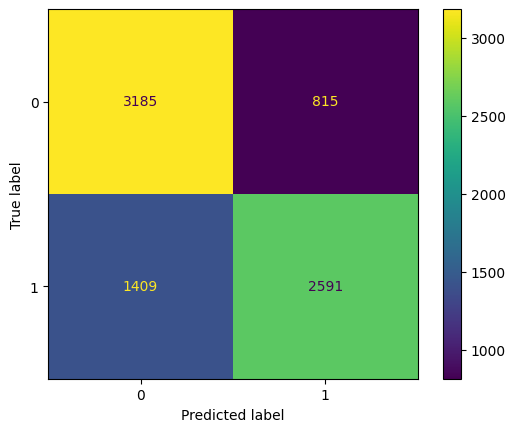

CNN Accuracy: 0.722
CNN Precision WAT: 0.6932956029603831
CNN Precision NAT: 0.7607163828537874
CNN Recall WAT: 0.79625
CNN Recall NAT: 0.64775
CNN F1 WAT: 0.7412148010239701
CNN F1 NAT: 0.6997029435592762


In [29]:
for train_index, test_index in kf.split(Imgs):
  count += 1
  print(f"\n--- Fold {count} ---") #to test
  trainX, testX = Imgs[train_index], Imgs[test_index]
  trainY, testY = lbl[train_index], lbl[test_index]

  # --- Print details of the current split ---
  print(f"X_train shape: {trainX.shape}")
  print(f"X_test shape: {testX.shape}")
  print(f"y_train shape: {trainY.shape}")
  print(f"y_test shape: {testY.shape}")

# removing for test
#  trainX = np.array(trainX)
#  testX = np.array(testX)
#  trainY = np.array(trainY)
#  testY = np.array(testY)

  batch_size=64
  validation_size=int(0.25*samplesize)
  X_train=trainX[validation_size:]
  y_train=trainY[validation_size:]
  X_valid=trainX[:validation_size]
  y_valid=trainY[:validation_size]

  Twodims=[] ; values = range(X_train.shape[0])
  for x in values:
    tst=X_train[x]
    tst2=np.reshape(tst,(50,50))  # Reshape from 1D (2500) to 2D (50,50)
    Twodims.append(tst2)
    Twodims.append(np.flip(tst2,0))  # Flip along axis 0 (vertical flip)
    Twodims.append(np.flip(tst2,1)) # Flip along axis 1 (horizontal flip)
    Twodims.append(np.rot90(tst2,1))  # Rotate 90 degrees clockwise
    Twodims.append(np.rot90(tst2,2))  # Rotate 180 degrees clockwise
    Twodims.append(np.rot90(tst2,3)) # Rotate 270 degrees clockwise
  X_train = np.array(Twodims,dtype='uint8')
  y_train = pd.DataFrame(y_train)
  y_train = y_train.loc[y_train.index.repeat(6)]

  Twodims=[] ; values = range(X_valid.shape[0])
  for x in values:
    tst=X_valid[x]
    tst2=np.reshape(tst,(50,50))
    Twodims.append(tst2)
  X_valid = np.array(Twodims,dtype='uint8')

  Twodims=[] ; values = range(testX.shape[0])
  for x in values:
    tst=testX[x]
    tst2=np.reshape(tst,(50,50))
    Twodims.append(tst2)
  testX = np.array(Twodims,dtype='uint8')

  # Add a channel dimension for Keras Conv2D layers (grayscale images have 1 channel)
  X_train = np.expand_dims(X_train, axis=-1)
  X_valid = np.expand_dims(X_valid, axis=-1)
  testX = np.expand_dims(testX, axis=-1)

  best_model_file = 'CNN.keras'
  model=Sequential()

  model.add(Conv2D(32, 3, strides=1, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.01),  # L1 regularization
                  input_shape=(50, 50, 1)))
  model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
  model.add(Dropout(0.50))

  model.add(Conv2D(64, 3, strides=1, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(0.01)))  # L1 regularization
  model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
  model.add(Dropout(0.20))
  model.add(Conv2D(64, 3, strides=1, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(0.01)))  # L1 regularization
  model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
  model.add(Dropout(0.20))
  model.add(Conv2D(128, 3, strides=1, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(0.01)))  # L1 regularization

  model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
  model.add(Dropout(0.20))

  model.add(Conv2D(256, 3, strides=1, activation='relu', padding='same',
                   kernel_regularizer=regularizers.l2(0.01)))  # L1 regularization
  model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
  model.add(Dropout(0.20))

    # Flatten layer and dense layers
  model.add(Flatten())
  model.add(Dense(512, activation='relu', #kernel_regularizer='l2'))
                  kernel_regularizer=regularizers.l2(0.01)))  # L1 regularization

  model.add(Dropout(0.5))
  model.add(Dense(2, activation='sigmoid'))


  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  monitor=EarlyStopping(monitor='val_accuracy',min_delta=1e-4,patience=20,verbose=1,mode='auto')
  checkpoint=ModelCheckpoint(best_model_file,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
  input_shape = (None,50,50,1)
  model.build(input_shape)

  model.fit(X_train,y_train,validation_data=(X_valid, y_valid),batch_size=batch_size,epochs=50,callbacks=[monitor,checkpoint])

  model=load_model(best_model_file)
  predY=model.predict(testX)
  ConfMat=confusion_matrix(pd.DataFrame(testY).idxmax(axis=1),pd.DataFrame(predY).idxmax(axis=1))
  ConfMat_CNN2D.append(ConfMat)

  os.remove("CNN.keras")
  gc.collect()
  tf.keras.backend.clear_session()
  print(count,'/','50')


CNN=np.sum(ConfMat_CNN2D,axis = 0)
print(CNN)
disp = ConfusionMatrixDisplay(confusion_matrix=CNN)
disp.plot()
plt.show()
APR=CNN
CNN_acc=(APR[0,0]+APR[1,1])/np.sum(APR)
CNN_WAT_P=APR[0,0]/sum(APR[:,0])
CNN_NAT_P=APR[1,1]/sum(APR[:,1])
CNN_WAT_R=APR[0,0]/sum(APR[0,:])
CNN_NAT_R=APR[1,1]/sum(APR[1,:])
CNN_WAT_F1=2*(CNN_WAT_P*CNN_WAT_R)/(CNN_WAT_P+CNN_WAT_R)
CNN_NAT_F1=2*(CNN_NAT_P*CNN_NAT_R)/(CNN_NAT_P+CNN_NAT_R)
print("CNN Accuracy: " + str(CNN_acc))
print("CNN Precision WAT: " + str(CNN_WAT_P))
print("CNN Precision NAT: " + str(CNN_NAT_P))
print("CNN Recall WAT: " + str(CNN_WAT_R))
print("CNN Recall NAT: " + str(CNN_NAT_R))
print("CNN F1 WAT: " + str(CNN_WAT_F1))
print("CNN F1 NAT: " + str(CNN_NAT_F1))

In [30]:
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet')
pretrained_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=batch_size, epochs=50, verbose=True)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.7546 - loss: 1.2227 - val_accuracy: 0.7200 - val_loss: 1.2086
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7488 - loss: 1.1450 - val_accuracy: 0.7200 - val_loss: 1.1319
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7482 - loss: 1.0847 - val_accuracy: 0.7000 - val_loss: 1.1076
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7657 - loss: 1.0175 - val_accuracy: 0.7300 - val_loss: 1.0413
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7574 - loss: 0.9838 - val_accuracy: 0.7500 - val_loss: 0.9867
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7418 - loss: 0.9478 - val_accuracy: 0.5000 - val_loss: 1.1172
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7348 - loss: 0.9143 - val_accuracy: 0.7000 - val_loss: 0.9286
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7405 - loss: 0.8699 - val_accuracy: 0.7200 - val_l

In [32]:
max_epoch = len(history.history['accuracy']) + 1
print(max_epoch)
epoch_list =  list (range(1,max_epoch))

51


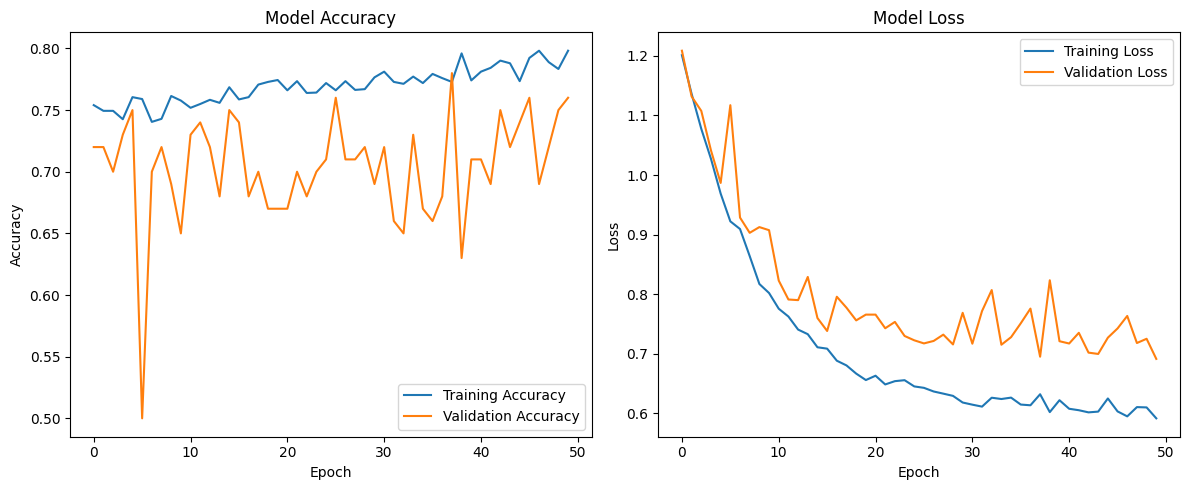

In [33]:
import matplotlib.pyplot as plt

# Plot Model Accuracy
plt.figure(figsize=(12, 5))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Display the plots
plt.tight_layout()
plt.show()


In [38]:
CNN_acc = (APR[0,0]+APR[1,1])/np.sum(APR) * 100 # Multiply by 100 for percentage
CNN_WAT_P = APR[0,0]/sum(APR[:,0]) * 100
CNN_NAT_P = APR[1,1]/sum(APR[:,1]) * 100
CNN_WAT_R = APR[0,0]/sum(APR[0,:]) * 100
CNN_NAT_R = APR[1,1]/sum(APR[1,:]) * 100
CNN_WAT_F1 = 2*( (CNN_WAT_P/100)*(CNN_WAT_R/100) ) / ( (CNN_WAT_P/100) + (CNN_WAT_R/100) ) * 100 # Convert back to ratio for F1 calc
CNN_NAT_F1 = 2*( (CNN_NAT_P/100)*(CNN_NAT_R/100) ) / ( (CNN_NAT_P/100) + (CNN_NAT_R/100) ) * 100
print(f"CNN Accuracy: {CNN_acc:.2f}%") # Use f-string for formatting to 2 decimal places
print(f"CNN Precision WAT: {CNN_WAT_P:.2f}%")
print(f"CNN Precision NAT: {CNN_NAT_P:.2f}%")
print(f"CNN Recall WAT: {CNN_WAT_R:.2f}%")
print(f"CNN Recall NAT: {CNN_NAT_R:.2f}%")
print(f"CNN F1 WAT: {CNN_WAT_F1:.2f}%")
print(f"CNN F1 NAT: {CNN_NAT_F1:.2f}%")

CNN Accuracy: 72.20%
CNN Precision WAT: 69.33%
CNN Precision NAT: 76.07%
CNN Recall WAT: 79.62%
CNN Recall NAT: 64.78%
CNN F1 WAT: 74.12%
CNN F1 NAT: 69.97%
